## 1. Importing Necessary Libraries

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import soundfile as sf

import warnings
warnings.filterwarnings('ignore')

DATA_DIR = os.path.join("..", "data", "raw")

TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "audios", "train")

TRAIN_CSV = os.path.join(DATA_DIR, "csvs", "train.csv")
train_df = pd.read_csv(TRAIN_CSV)

## 2. Robust Audio Loader

In [10]:
def load_audio_safe(path):
    try:
        audio, sr = sf.read(path)
        return audio, sr
    except Exception:
        try:
            audio, sr = librosa.load(path, sr=None)
            return audio, sr
        except Exception:
            return None, None


durations = []
failed_files = []

for fname in train_df["filename"]:
    if not fname.endswith(".wav"):
        fname += ".wav"

    path = os.path.join(TRAIN_AUDIO_DIR, fname)
    audio, sr = load_audio_safe(path)

    if audio is None:
        failed_files.append(fname)
        continue

    durations.append(len(audio) / sr)

durations = np.array(durations)

print("Files processed successfully:", len(durations))
print("Files failed to load:", len(failed_files))
print(
    "Duration stats (sec):",
    "Min:", round(durations.min(), 2),
    "Max:", round(durations.max(), 2),
    "Mean:", round(durations.mean(), 2)
)

Files processed successfully: 276
Files failed to load: 133
Duration stats (sec): Min: 20.84 Max: 61.04 Mean: 48.32


#### A robust audio loader was used to compute durations while tracking files that failed to decode.

## 3. Feature Extraction Plan

#### For grammar scoring, we focus on features that capture speech characteristics, not just waveform:

#### I) MFCCs – captures spectral shape, widely used in speech analysis

#### II) Chroma features – pitch content

#### III) Spectral contrast – timbre variations

#### IV) Zero-crossing rate – rough estimate of speech activity

#### V) Root-mean-square energy (RMSE) – loudness/voice activity

#### We will also average across time to create fixed-length feature vectors per audio.

In [11]:
# Take one valid file as example
for fname in train_df["filename"]:
    if not fname.endswith(".wav"):
        fname += ".wav"

    path = os.path.join(TRAIN_AUDIO_DIR, fname)
    audio, sr = load_audio_safe(path)

    if audio is not None and sr is not None and len(audio) > 0:
        sample_file = fname
        break

print("Using sample file:", sample_file)

Using sample file: audio_127.wav


In [12]:
# MFCC
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
mfccs_mean = np.mean(mfccs, axis=1)

# Chroma
chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
chroma_mean = np.mean(chroma, axis=1)

# Spectral contrast
contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
contrast_mean = np.mean(contrast, axis=1)

# Zero-crossing rate
zcr = librosa.feature.zero_crossing_rate(y=audio)
zcr_mean = np.mean(zcr)

# RMSE
rmse = librosa.feature.rms(y=audio)
rmse_mean = np.mean(rmse)

# Combine features
features_sample = np.concatenate([
    mfccs_mean,
    chroma_mean,
    contrast_mean,
    [zcr_mean],
    [rmse_mean]
])

print("Feature vector shape:", features_sample.shape)

Feature vector shape: (34,)


#### Feature Extraction Error and Fix

#### The error occurred because the selected audio file failed to load correctly, resulting in an empty (`None`) audio signal. Librosa requires a valid audio array to compute spectrogram-based features such as MFCCs.

#### To fix this, a valid audio file is first selected by checking successful loading using a robust audio loader. Feature extraction is then performed only on files with non-empty audio data. This ensures stable and error-free computation of MFCC, Chroma, Spectral Contrast, Zero-Crossing Rate, and RMSE features.


## 4. Visualize Features

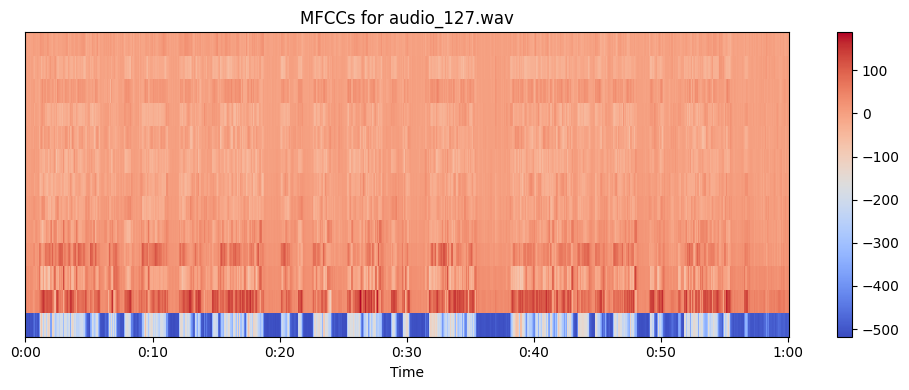

In [13]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title(f"MFCCs for {sample_file}")
plt.tight_layout()
plt.show()

#### MFCC Visualization – Explanation

##### This MFCC graph shows how the **spectral characteristics of speech** change over time.

##### - **X-axis (Time):** Progression of the audio from start to end.
##### - **Y-axis (MFCC coefficients):** Each band represents a cepstral coefficient capturing vocal tract shape and articulation.
##### - **Color intensity:**  
#####  - Warm colors (red/orange) → strong, clear speech energy  
#####  - Cool colors (blue) → silence, pauses, or weak speech

#### What this graph indicates
##### - Consistent warm regions suggest **continuous and stable speech**.
##### - Blue patches represent **natural pauses**.
##### - Lack of random patterns indicates **clean audio quality**.

#### Why MFCCs matter for grammar scoring
##### MFCCs help the model learn:
##### - Pronunciation consistency
##### - Fluency and rhythm
##### - Clarity of articulation

##### > The model does not understand grammar rules directly; it learns patterns from how correct speech sounds.


## 5. Loop Through All Audio to Build Feature Matrix

In [14]:
feature_list = []
valid_filenames = []

for fname in train_df["filename"]:
    # Ensure .wav extension
    if not fname.endswith(".wav"):
        fname += ".wav"

    path = os.path.join(TRAIN_AUDIO_DIR, fname)

    # Safe audio loading
    audio, sr = load_audio_safe(path)
    if audio is None:
        continue

    # Ensure mono audio
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)

    try:
        # MFCCs (13)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)

        # Chroma
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Spectral Contrast
        nyquist = sr / 2
        n_bands = min(6, int(np.log2(nyquist / 200)))  # adaptive bands

        contrast = librosa.feature.spectral_contrast(
            y=audio,
            sr=sr,
            fmin=200,
            n_bands=n_bands
        )
        contrast_mean = np.mean(contrast, axis=1)

        # Zero Crossing Rate
        zcr_mean = np.mean(librosa.feature.zero_crossing_rate(y=audio))

        # Root Mean Square Energy
        rmse_mean = np.mean(librosa.feature.rms(y=audio))

        # Combine all features
        features = np.concatenate([
            mfccs_mean,
            chroma_mean,
            contrast_mean,
            [zcr_mean],
            [rmse_mean]
        ])

        feature_list.append(features)
        valid_filenames.append(fname)

    except Exception as e:
        print(f"Feature extraction failed for {fname}: {e}")
        continue


feature_names = (
    [f"mfcc_{i}" for i in range(13)] +
    [f"chroma_{i}" for i in range(12)] +
    [f"contrast_{i}" for i in range(7)] +
    ["zcr", "rmse"]
)

# X_features = pd.DataFrame(
#     feature_list,
#     columns=feature_names,
#     index=valid_filenames
# )

X_features = pd.DataFrame(
    feature_list,
    columns=feature_names
)

X_features["filename"] = valid_filenames


print("Feature matrix shape:", X_features.shape)


Feature matrix shape: (276, 35)


In [15]:
cols = ["filename"] + [c for c in X_features.columns if c != "filename"]
X_features = X_features[cols]


print(X_features.head())
print(X_features.columns)

          filename      mfcc_0     mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
0    audio_127.wav -334.760785  73.368503  12.660144  35.315689  10.993047   
1     audio_34.wav -405.899751  83.043493   7.323974  36.095239   9.198061   
2  audio_120_2.wav -198.565367  41.055354   1.480458   6.861272  -0.193342   
3    audio_224.wav -371.887858  59.955844   8.750488  10.181027 -10.947562   
4    audio_342.wav -230.348703  68.919512  -9.889165   1.354586 -38.849326   

      mfcc_5     mfcc_6     mfcc_7     mfcc_8  ...  chroma_11  contrast_0  \
0   0.653920  -5.072692 -11.060136  -6.161673  ...   0.246475   22.667678   
1  28.409856 -10.421589  -7.050345  -4.710257  ...   0.447543   14.463963   
2  -3.645291  -7.439322  -5.805482  -7.321692  ...   0.491897   17.060642   
3  -8.876055 -12.146105  -5.762134 -14.933362  ...   0.415742   20.349934   
4 -16.509183  -9.842053 -14.242143  -7.622278  ...   0.451341   20.623592   

   contrast_1  contrast_2  contrast_3  contrast_4  contrast_5  contr

In [16]:
# Fix NaNs/Infs before saving
X_features = X_features.replace([np.inf, -np.inf], np.nan)

# Fill rmse NaNs with median (safe)
if "rmse" in X_features.columns:
    X_features["rmse"] = X_features["rmse"].fillna(X_features["rmse"].median())

# If any other NaNs exist, fill with column medians
X_features = X_features.apply(lambda col: col.fillna(col.median()) if col.isna().any() else col)


## 6. Save Features for Future Use

In [ ]:
SAVE_PATH = os.path.join("..", "data", "processed", "train_audio_features.csv")
X_features.to_csv(SAVE_PATH, index=False)
# X_features.to_csv("train_audio_features.csv", index=False)
print("Features saved successfully.")

Features saved successfully.
